In [ ]:
!pip install torch torchvision

In [ ]:
# https://gist.github.com/AFAgarap/4f8a8d8edf352271fa06d85ba0361f26

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

In [2]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [3]:
batch_size = 512
epochs = 200
learning_rate = 1e-3

In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

Extracting /root/torch_datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw



Extracting /root/torch_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Without Dropouts

In [5]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.sigmoid(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.sigmoid(activation)
        return reconstructed

In [6]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device = ",device)

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=784)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.MSELoss()

device =  cuda


In [7]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

In [ ]:
losses = []
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 784)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    losses.append(loss)
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

epoch : 1/200, recon loss = 0.06415338
epoch : 2/200, recon loss = 0.04154352
epoch : 3/200, recon loss = 0.03541024
epoch : 4/200, recon loss = 0.02795628
epoch : 5/200, recon loss = 0.02329513
epoch : 6/200, recon loss = 0.02071499
epoch : 7/200, recon loss = 0.01866129
epoch : 8/200, recon loss = 0.01691499
epoch : 9/200, recon loss = 0.01557805
epoch : 10/200, recon loss = 0.01403124
epoch : 11/200, recon loss = 0.01278244
epoch : 12/200, recon loss = 0.01190003
epoch : 13/200, recon loss = 0.01126922
epoch : 14/200, recon loss = 0.01070535
epoch : 15/200, recon loss = 0.01022582
epoch : 16/200, recon loss = 0.00979880
epoch : 17/200, recon loss = 0.00939511
epoch : 18/200, recon loss = 0.00899579
epoch : 19/200, recon loss = 0.00866037
epoch : 20/200, recon loss = 0.00837372
epoch : 21/200, recon loss = 0.00811422
epoch : 22/200, recon loss = 0.00787735
epoch : 23/200, recon loss = 0.00767605
epoch : 24/200, recon loss = 0.00750453
epoch : 25/200, recon loss = 0.00734724
epoch : 2

In [44]:
#model = AE(nn.module)
model.load_state_dict(torch.load("Mnist_without_dropout.pt"))
model.eval()


AEDropouts(
  (encoder_hidden_layer): Linear(in_features=784, out_features=128, bias=True)
  (drop_hl1): Dropout(p=0.5, inplace=False)
  (encoder_output_layer): Linear(in_features=128, out_features=128, bias=True)
  (decoder_hidden_layer): Linear(in_features=128, out_features=128, bias=True)
  (drop_hl2): Dropout(p=0.5, inplace=False)
  (decoder_output_layer): Linear(in_features=128, out_features=784, bias=True)
)

In [47]:
test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=10, shuffle=False
)

test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        test_examples = batch_features.view(-1, 784)
        reconstruction = model(test_examples)
        break

## Compare the results

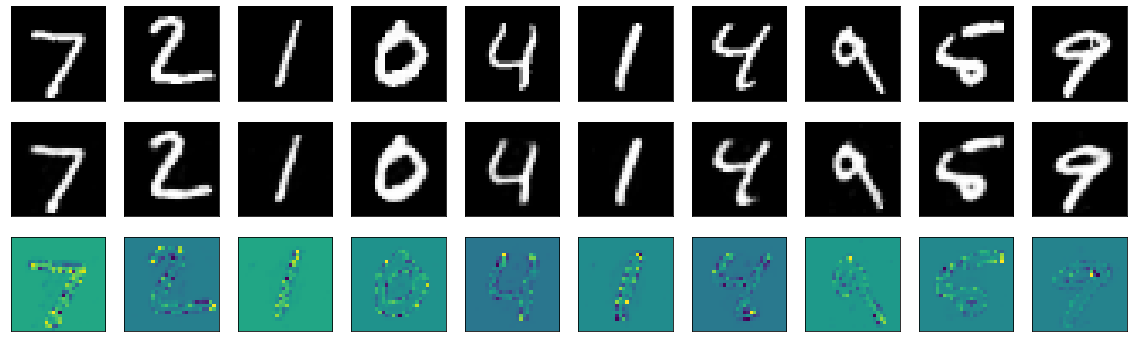

In [48]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 6))
    for index in range(number):
        # display original
        ax = plt.subplot(3, number, index + 1)
        plt.imshow(test_examples[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, number, index + 1 + number)
        plt.imshow(reconstruction[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display difference
        ax = plt.subplot(3, number, index + 2*number + 1)
        original = test_examples[index].numpy().reshape(28, 28)
        generated = reconstruction[index].numpy().reshape(28, 28)
        diff = original - generated
        plt.imshow(diff,cmap="viridis")
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # do xor and display difference
        #ax = plt.subplot(4, number, index + 3*number + 1)
        #original = test_examples[index].numpy().reshape(28, 28)
        #generated = reconstruction[index].numpy().reshape(28, 28)
        # thresh_or = original > 0
        # original[thresh_or] = 1

        # thresh_gen = generated > 0
        # generated[thresh_gen] = 1
        # diff_xor = original - generated
        # plt.imshow(diff,cmap="viridis")
    plt.show()



## Loss graph

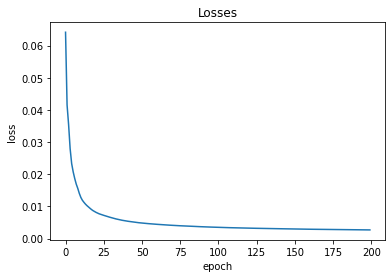

In [ ]:
plt.plot(losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses');

## Check all the parameters

In [ ]:
for item in model.parameters():
  print(item.shape)

torch.Size([128, 784])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([784, 128])
torch.Size([784])


## Print the weights learned in 1st connection

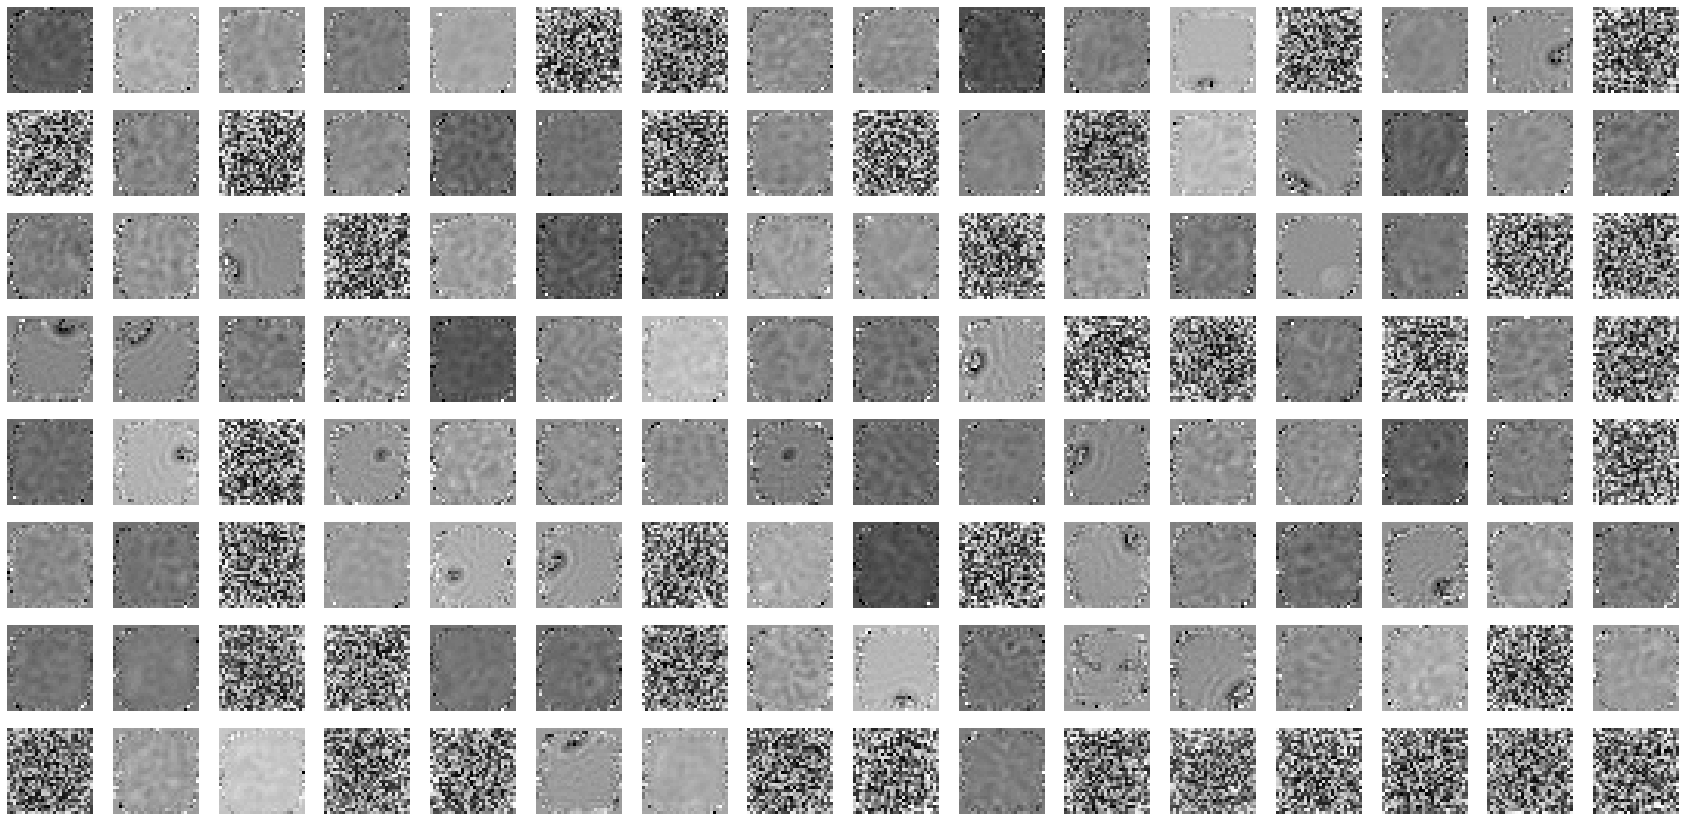

In [ ]:
total_img = 128
num_pr = 16 # number per row

counter = 1
plt.figure(figsize=(30,30))
plt.axis('off')

for item in model.parameters():
  
  for item_1 in item:
    img_weights = torch.reshape(item_1, (28, 28))
    #print(item_1.shape)
    plt.subplot(num_pr, num_pr, counter)
    plt.axis('off')
    plt.imshow(img_weights.detach().numpy(),cmap="gray")
    counter += 1
    #plt.figure(figsize=(2,2))
    #plt.imshow(img_weights.detach().numpy(),cmap="gray")
    #plt.show()
    #print(item_1.reshape((28,28)))
    #break
  plt.show()
  break

## Print the biases learned in 1st connection

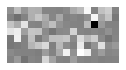

In [ ]:


counter = 1
plt.figure(figsize=(2,2))
plt.axis('off')

k = 0
for item in model.parameters():
  if k == 0:
    k = 1
    continue
  #print(item.shape)
  img_weights = torch.reshape(item, (8, 16))
  plt.axis('off')
  plt.imshow(img_weights.detach().numpy(),cmap="gray")
  plt.show()
  break

## Weights learned in the bottleneck

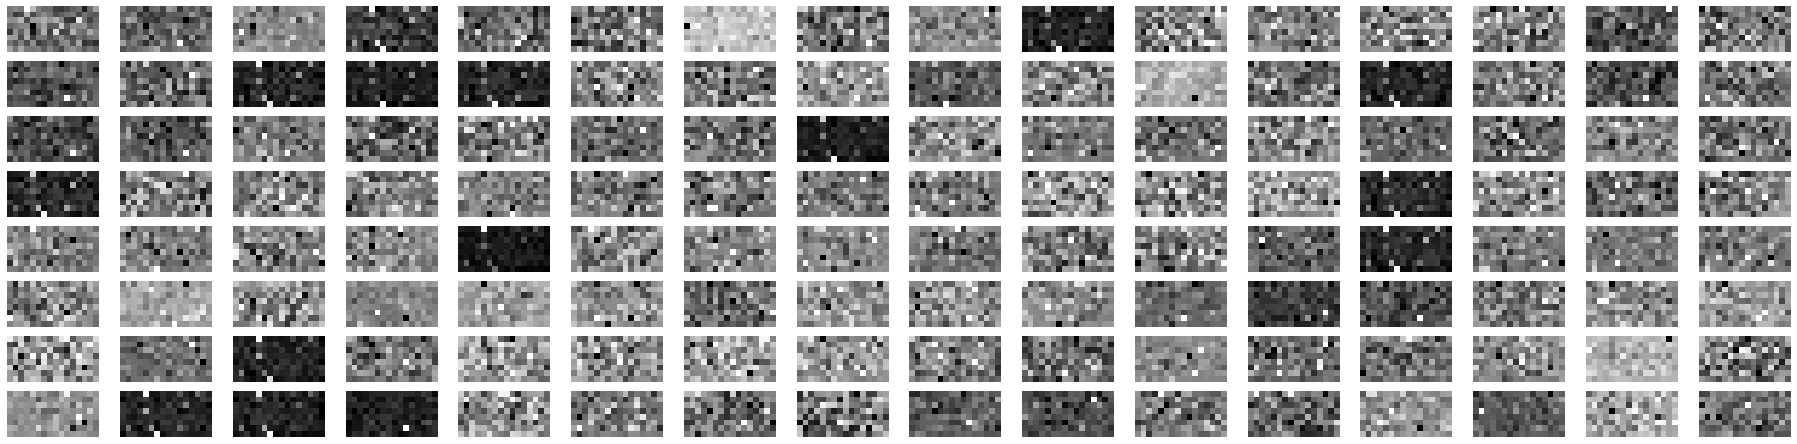

In [ ]:
total_img = 128
num_pr = 16 # number per row

counter = 1
plt.figure(figsize=(32,16))
plt.axis('off')

k = 0
for item in model.parameters():
  if k <= 1:
    k += 1
    continue
  #print(item.shape)
  for item_1 in item:
    try:
      #print("shape = ",item_1.shape[0])
      
      img_weights = torch.reshape(item_1, (8, 16))
      
      plt.subplot(num_pr, num_pr, counter)
      plt.axis('off')
      plt.imshow(img_weights.detach().numpy(),cmap="gray")
      counter += 1
      
    except:
      pass
  plt.show()
  break


In [ ]:
item.shape

torch.Size([128, 128])

## Biases of the bottleneck encoder

torch.Size([128])


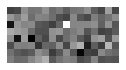

In [ ]:

counter = 1
plt.figure(figsize=(2,2))
plt.axis('off')

k = 0
for item in model.parameters():
  if k <= 2:
    k += 1
    continue
  print(item.shape)
  img_weights = torch.reshape(item_1, (8, 16))
  plt.imshow(img_weights.detach().numpy(),cmap="gray")
  plt.show()
  break


## Weights of the bottleneck decoder

torch.Size([128, 128])


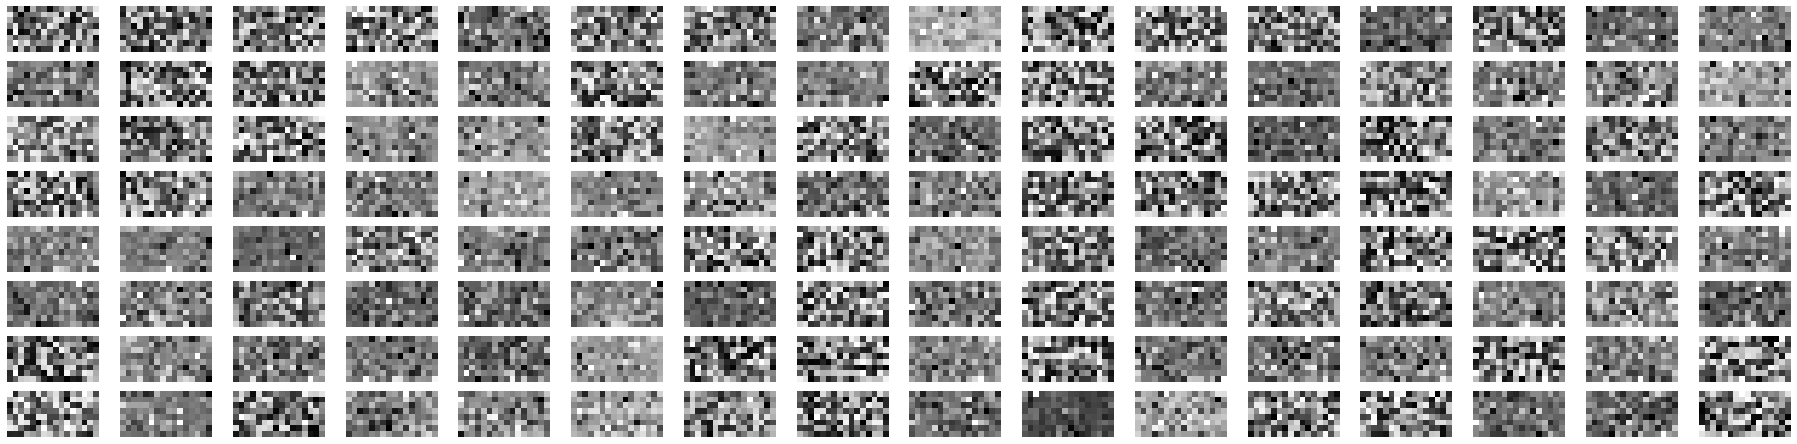

In [ ]:
total_img = 128
num_pr = 16 # number per row

counter = 1
plt.figure(figsize=(32,16))
plt.axis('off')

k = 0
for item in model.parameters():
  if k <= 3:
    k += 1
    continue
  print(item.shape)
  
  for item_1 in item:
    try:
      #print("shape = ",item_1.shape[0])
      
      img_weights = torch.reshape(item_1, (8, 16))
      
      plt.subplot(num_pr, num_pr, counter)
      plt.axis('off')
      plt.imshow(img_weights.detach().numpy(),cmap="gray")
      counter += 1
      
    except:
      pass
  plt.show()
  
  break

## Bias of the bottleneck decoder

torch.Size([128])


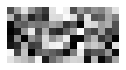

In [ ]:
counter = 1
plt.figure(figsize=(2,2))
plt.axis('off')

k = 0
for item in model.parameters():
  if k <= 4:
    k += 1
    continue
  print(item.shape)
  img_weights = torch.reshape(item_1, (8, 16))
  plt.imshow(img_weights.detach().numpy(),cmap="gray")
  plt.show()  
  break

In [ ]:
for item in model.parameters():
  print(item.shape)

torch.Size([128, 784])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([784, 128])
torch.Size([784])


## Decoder weights

torch.Size([784, 128])


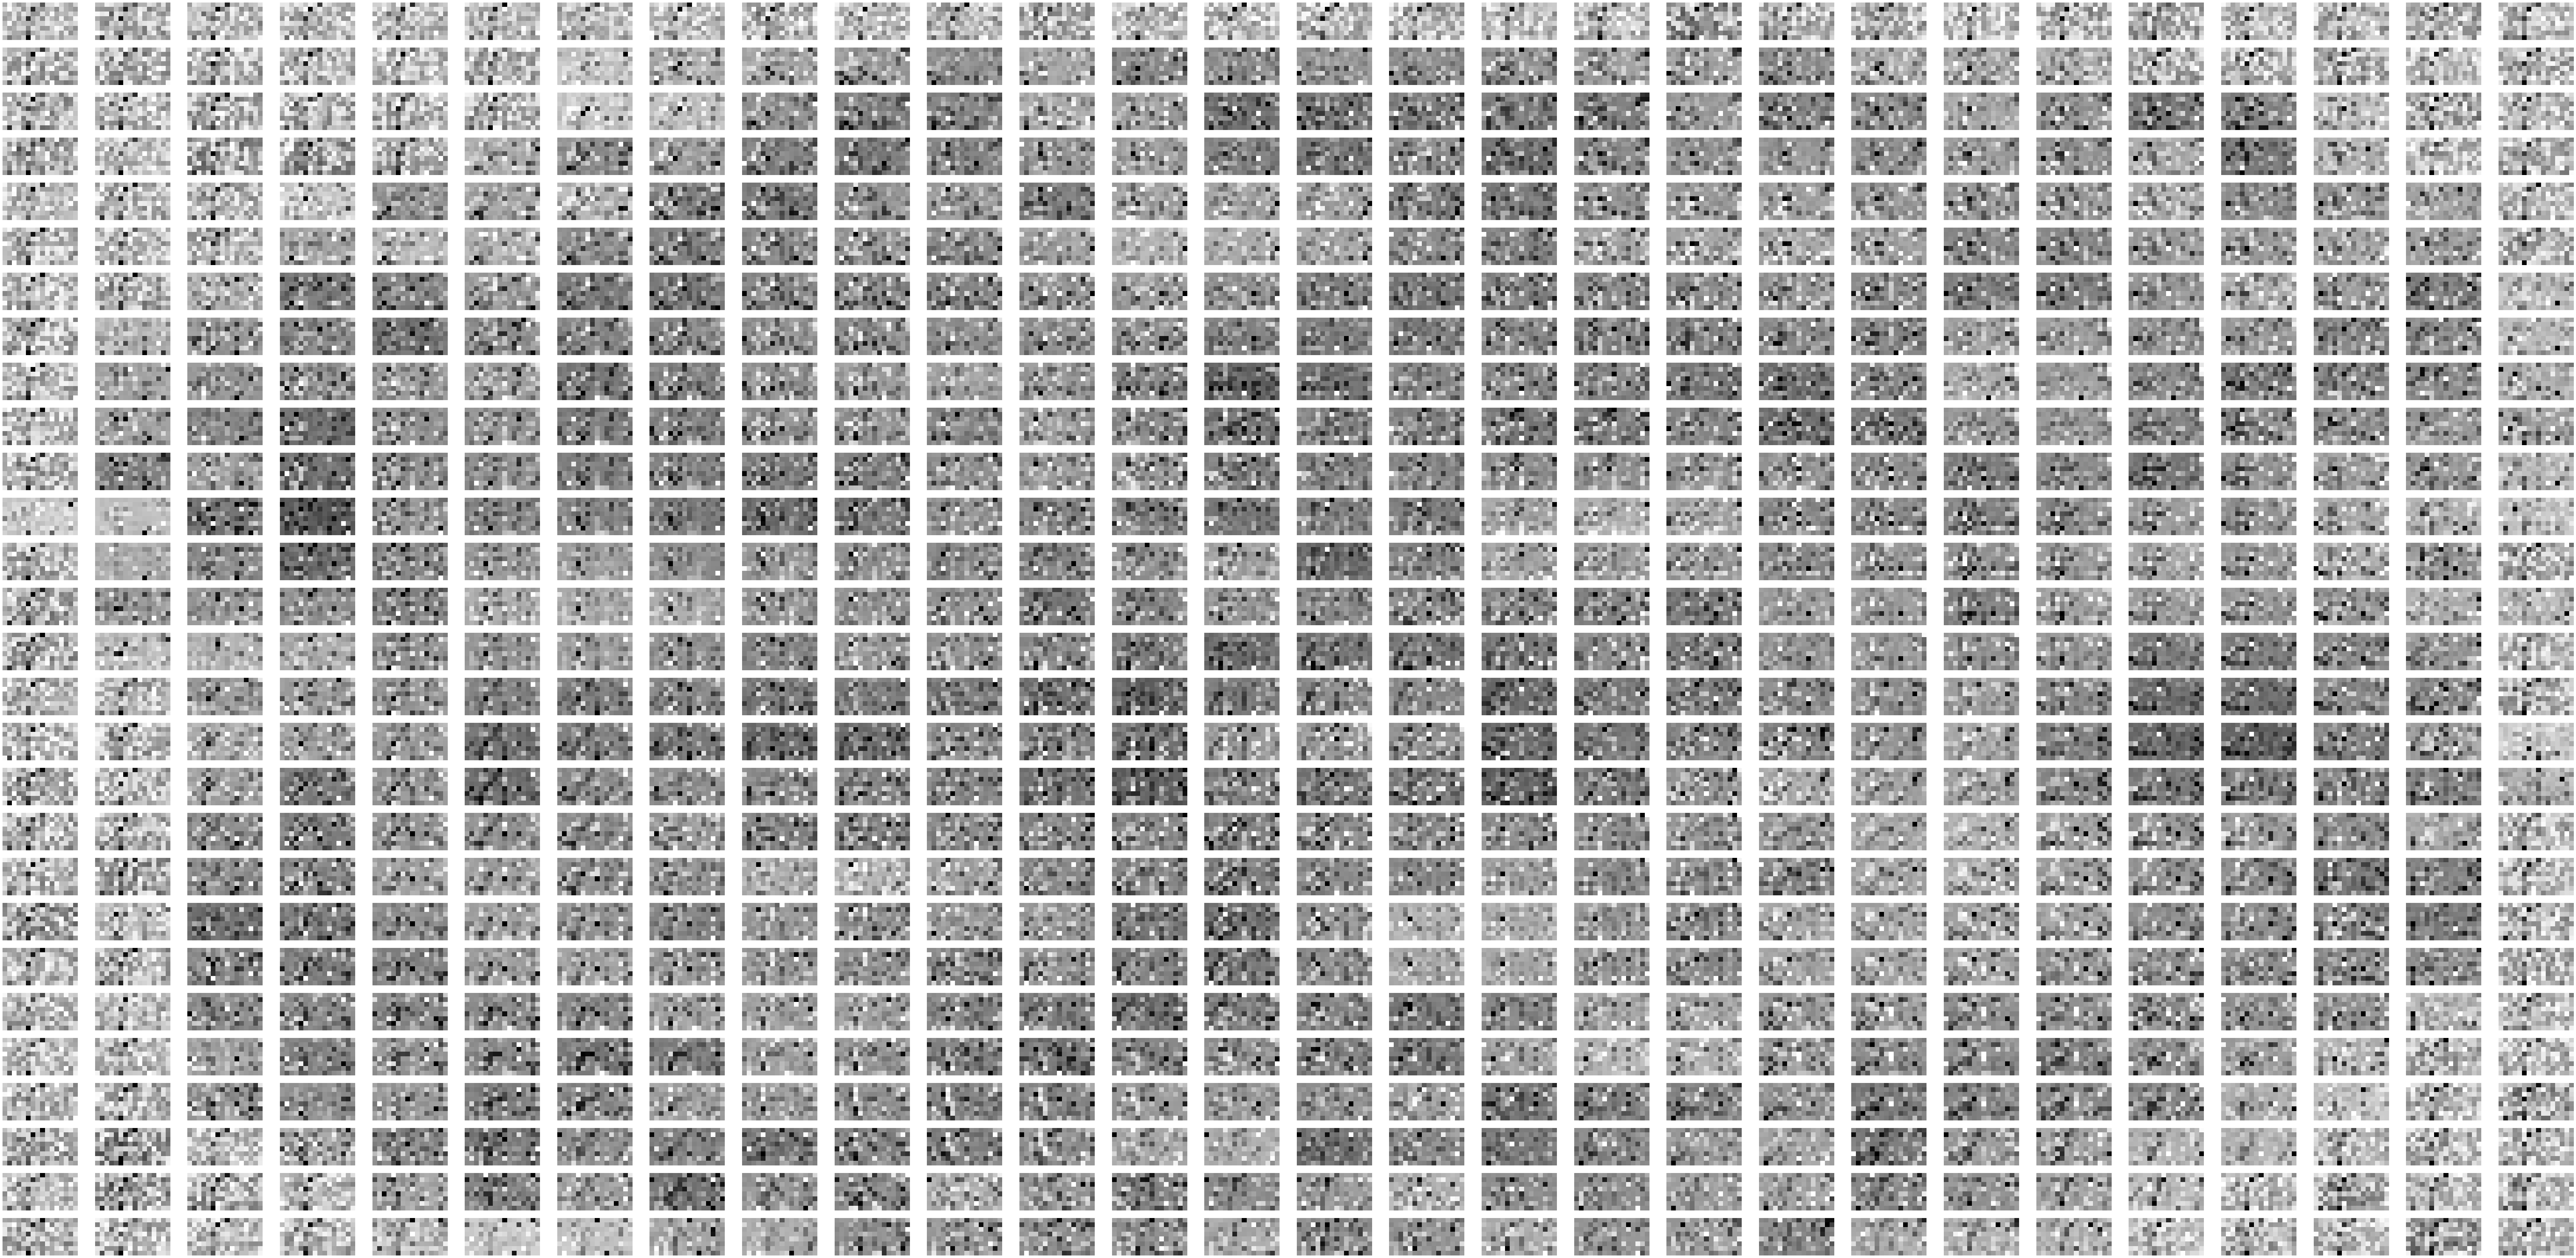

In [ ]:
total_img = 784
num_pr = 28 # number per row

counter = 1
plt.figure(figsize=(64*2,32*2))
plt.axis('off')

k = 0
for item in model.parameters():
  if k <= 5:
    k += 1
    continue
  print(item.shape)
  for item_1 in item:
    #print("shape = ",item_1.shape)
    img_weights = torch.reshape(item_1, (8, 16))
    plt.subplot(num_pr, num_pr, counter)
    plt.axis('off')
    plt.imshow(img_weights.detach().numpy(),cmap="gray")
    counter += 1
  plt.show()
  break

## Decoder biases

torch.Size([784])


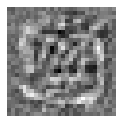

In [ ]:

counter = 1
plt.figure(figsize=(2,2))
plt.axis('off')
k = 0
for item in model.parameters():
  if k <= 6:
    k += 1
    continue
  print(item.shape)
  img_weights = torch.reshape(item, (28, 28))
  plt.axis('off')
  plt.imshow(img_weights.detach().numpy(),cmap="gray")

  break

In [ ]:
torch.save(model.state_dict(), "Mnist_without_dropout.pt")

# With Dropouts

In [24]:
class AEDropouts(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.drop_hl1 = nn.Dropout(0.5)
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.drop_hl2 = nn.Dropout(0.5)
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(self.drop_hl1(activation))
        
        code = self.encoder_output_layer(activation)
        code = torch.sigmoid(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(self.drop_hl1(activation))
        
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.sigmoid(activation)
        return reconstructed

In [25]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device = ",device)

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AEDropouts(input_shape=784)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.MSELoss()

device =  cuda


In [26]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

In [ ]:
# cool https://stackoverflow.com/questions/53419474/using-dropout-in-pytorch-nn-dropout-vs-f-dropout

In [ ]:
losses = []
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 784)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    losses.append(loss)
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

epoch : 1/200, recon loss = 0.06787991
epoch : 2/200, recon loss = 0.04734913
epoch : 3/200, recon loss = 0.04276034
epoch : 4/200, recon loss = 0.04104461
epoch : 5/200, recon loss = 0.03985566
epoch : 6/200, recon loss = 0.03901467
epoch : 7/200, recon loss = 0.03830852
epoch : 8/200, recon loss = 0.03779165
epoch : 9/200, recon loss = 0.03729005
epoch : 10/200, recon loss = 0.03686484
epoch : 11/200, recon loss = 0.03651264
epoch : 12/200, recon loss = 0.03613999
epoch : 13/200, recon loss = 0.03591668
epoch : 14/200, recon loss = 0.03566672
epoch : 15/200, recon loss = 0.03557408
epoch : 16/200, recon loss = 0.03536771
epoch : 17/200, recon loss = 0.03519088
epoch : 18/200, recon loss = 0.03508433
epoch : 19/200, recon loss = 0.03498988
epoch : 20/200, recon loss = 0.03485433
epoch : 21/200, recon loss = 0.03480767
epoch : 22/200, recon loss = 0.03472511
epoch : 23/200, recon loss = 0.03464253
epoch : 24/200, recon loss = 0.03453601
epoch : 25/200, recon loss = 0.03447530
epoch : 2

In [49]:
model.load_state_dict(torch.load("Mnist_with_dropout.pt"))
model.eval()

AEDropouts(
  (encoder_hidden_layer): Linear(in_features=784, out_features=128, bias=True)
  (drop_hl1): Dropout(p=0.5, inplace=False)
  (encoder_output_layer): Linear(in_features=128, out_features=128, bias=True)
  (decoder_hidden_layer): Linear(in_features=128, out_features=128, bias=True)
  (drop_hl2): Dropout(p=0.5, inplace=False)
  (decoder_output_layer): Linear(in_features=128, out_features=784, bias=True)
)

In [50]:
test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=10, shuffle=False
)

test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        test_examples = batch_features.view(-1, 784)
        reconstruction = model(test_examples)
        break

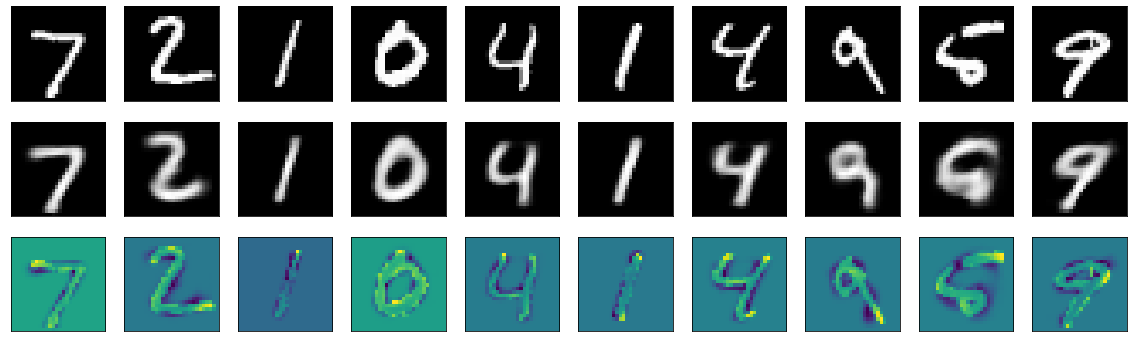

In [51]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 6))
    for index in range(number):
        # display original
        ax = plt.subplot(3, number, index + 1)
        plt.imshow(test_examples[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, number, index + 1 + number)
        plt.imshow(reconstruction[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display difference
        ax = plt.subplot(3, number, index + 2*number + 1)
        original = test_examples[index].numpy().reshape(28, 28)
        generated = reconstruction[index].numpy().reshape(28, 28)
        diff = original - generated
        plt.imshow(diff,cmap="viridis")
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


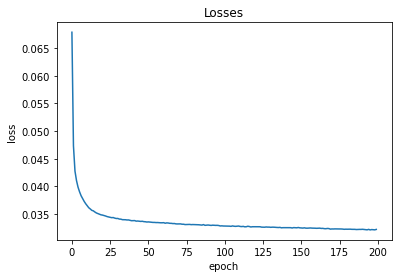

In [ ]:
plt.plot(losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses');

In [ ]:
for item in model.parameters():
  print(item.shape)

torch.Size([128, 784])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([784, 128])
torch.Size([784])


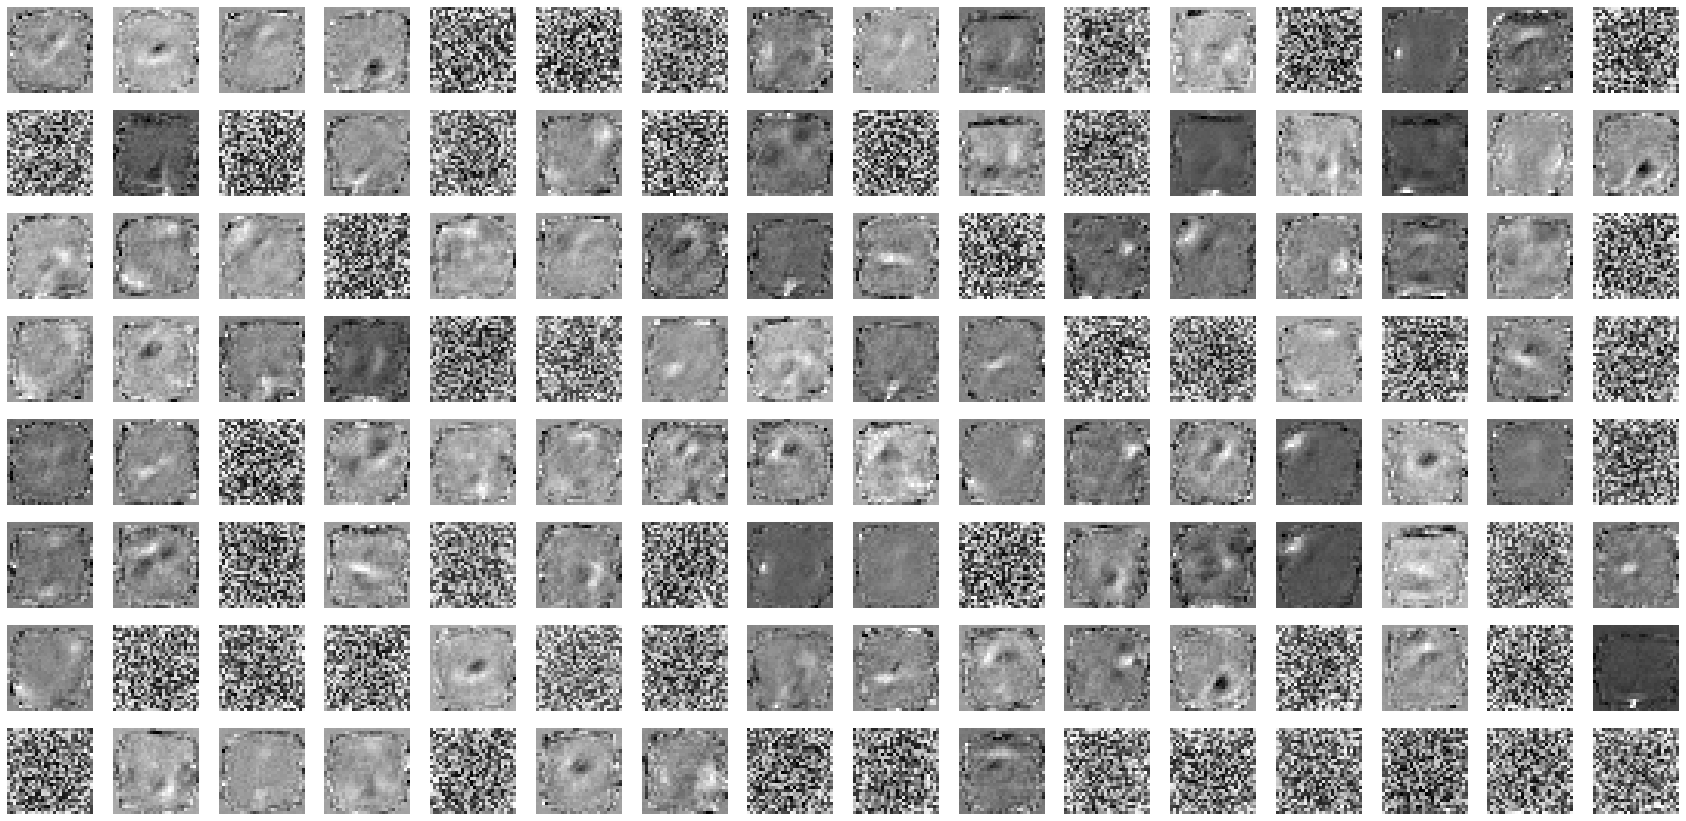

In [ ]:
total_img = 128
num_pr = 16 # number per row

counter = 1
plt.figure(figsize=(30,30))
plt.axis('off')

for item in model.parameters():
  
  for item_1 in item:
    img_weights = torch.reshape(item_1, (28, 28))
    #print(item_1.shape)
    plt.subplot(num_pr, num_pr, counter)
    plt.axis('off')
    plt.imshow(img_weights.detach().numpy(),cmap="gray")
    counter += 1
    #plt.figure(figsize=(2,2))
    #plt.imshow(img_weights.detach().numpy(),cmap="gray")
    #plt.show()
    #print(item_1.reshape((28,28)))
    #break
  plt.show()
  break

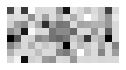

In [ ]:


counter = 1
plt.figure(figsize=(2,2))
plt.axis('off')

k = 0
for item in model.parameters():
  if k == 0:
    k = 1
    continue
  #print(item.shape)
  img_weights = torch.reshape(item, (8, 16))
  plt.axis('off')
  plt.imshow(img_weights.detach().numpy(),cmap="gray")
  plt.show()
  break

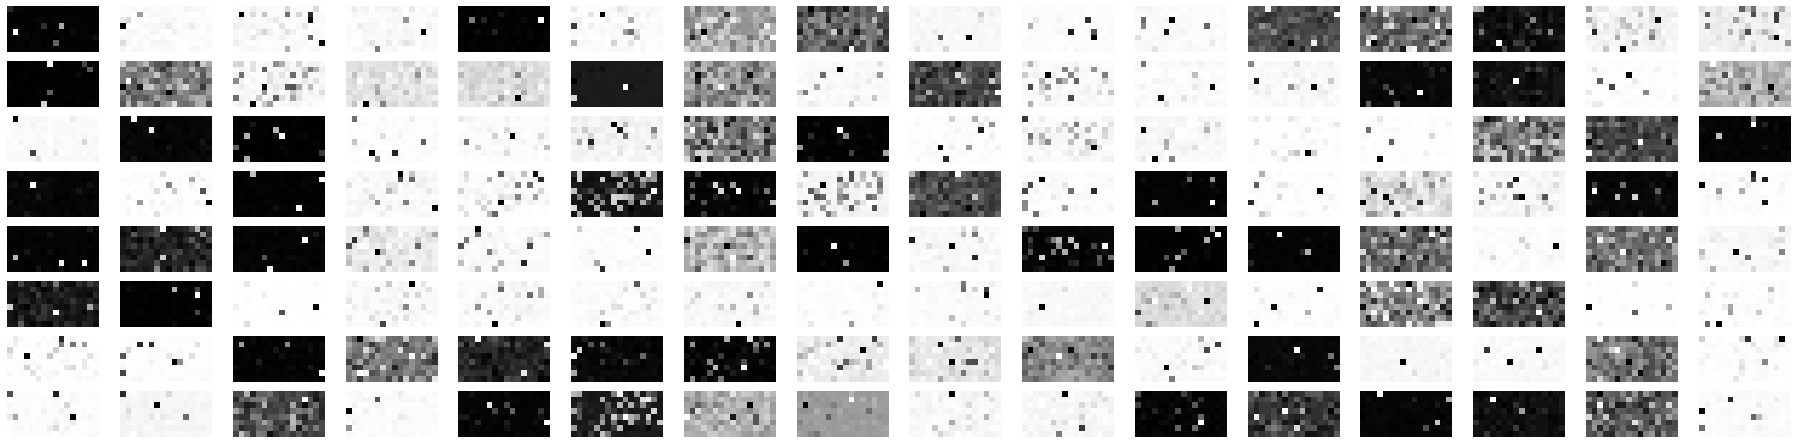

In [ ]:
total_img = 128
num_pr = 16 # number per row

counter = 1
plt.figure(figsize=(32,16))
plt.axis('off')

k = 0
for item in model.parameters():
  if k <= 1:
    k += 1
    continue
  #print(item.shape)
  for item_1 in item:
    try:
      #print("shape = ",item_1.shape[0])
      
      img_weights = torch.reshape(item_1, (8, 16))
      
      plt.subplot(num_pr, num_pr, counter)
      plt.axis('off')
      plt.imshow(img_weights.detach().numpy(),cmap="gray")
      counter += 1
      
    except:
      pass
  plt.show()
  break


torch.Size([128])


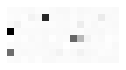

In [ ]:

counter = 1
plt.figure(figsize=(2,2))
plt.axis('off')

k = 0
for item in model.parameters():
  if k <= 2:
    k += 1
    continue
  print(item.shape)
  img_weights = torch.reshape(item_1, (8, 16))
  plt.imshow(img_weights.detach().numpy(),cmap="gray")
  plt.show()
  break


torch.Size([128, 128])


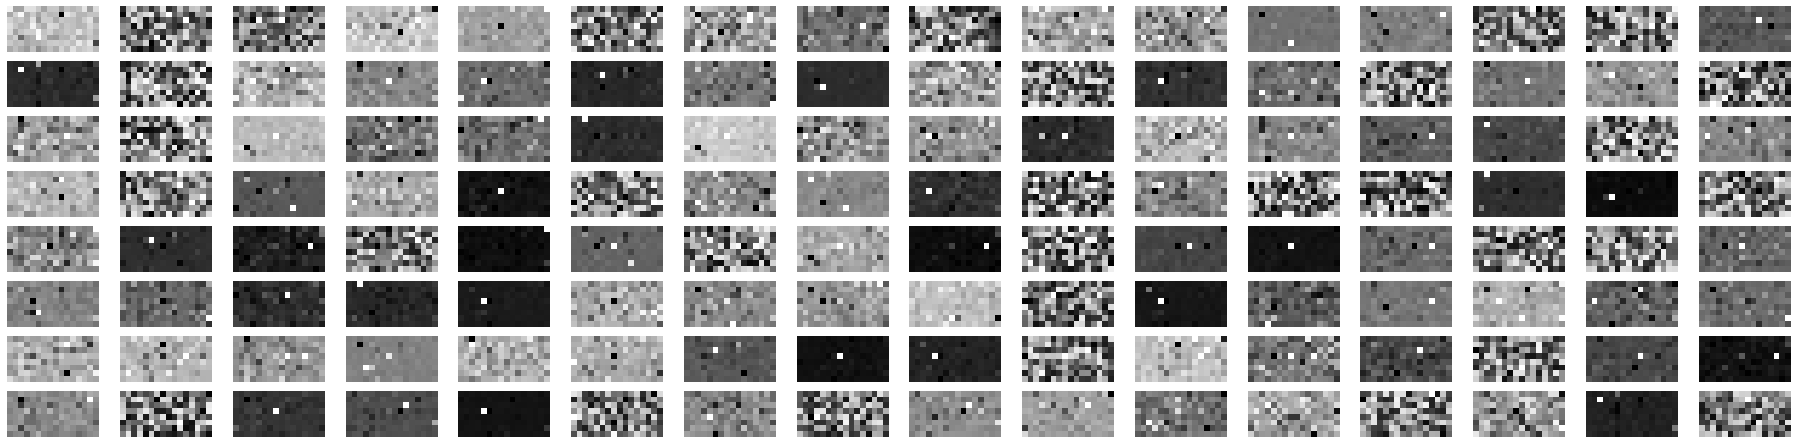

In [ ]:
total_img = 128
num_pr = 16 # number per row

counter = 1
plt.figure(figsize=(32,16))
plt.axis('off')

k = 0
for item in model.parameters():
  if k <= 3:
    k += 1
    continue
  print(item.shape)
  
  for item_1 in item:
    try:
      #print("shape = ",item_1.shape[0])
      
      img_weights = torch.reshape(item_1, (8, 16))
      
      plt.subplot(num_pr, num_pr, counter)
      plt.axis('off')
      plt.imshow(img_weights.detach().numpy(),cmap="gray")
      counter += 1
      
    except:
      pass
  plt.show()
  
  break

torch.Size([128])


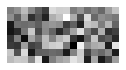

In [ ]:
counter = 1
plt.figure(figsize=(2,2))
plt.axis('off')

k = 0
for item in model.parameters():
  if k <= 4:
    k += 1
    continue
  print(item.shape)
  img_weights = torch.reshape(item_1, (8, 16))
  plt.imshow(img_weights.detach().numpy(),cmap="gray")
  plt.show()  
  break

torch.Size([784, 128])


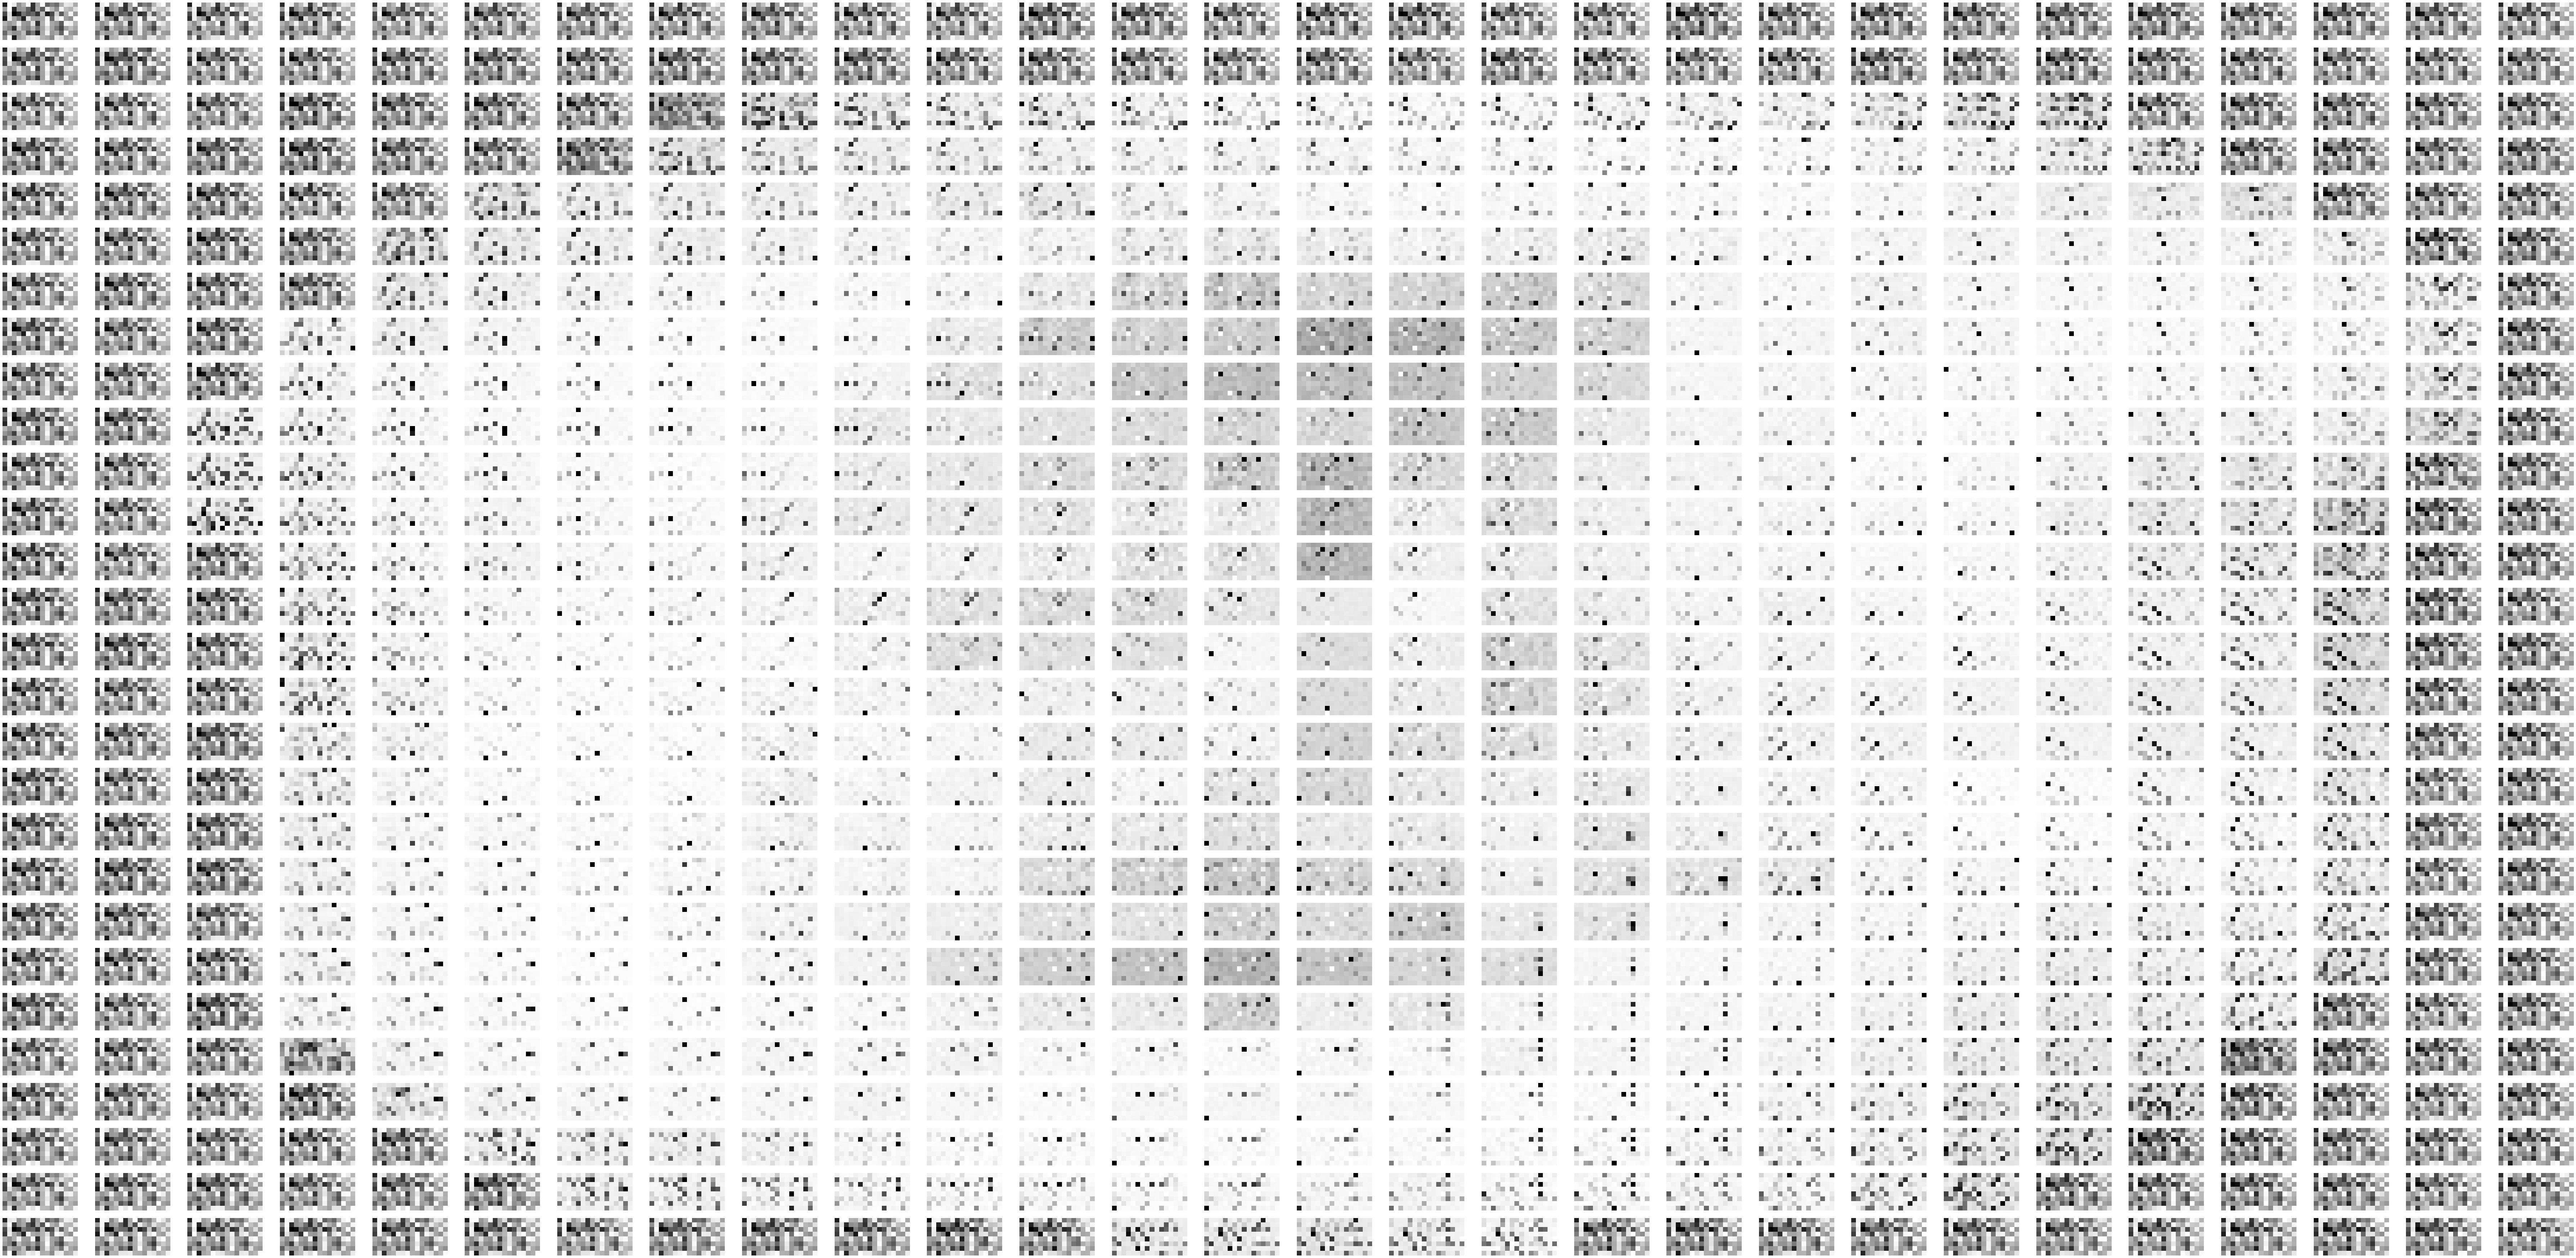

In [ ]:
total_img = 784
num_pr = 28 # number per row

counter = 1
plt.figure(figsize=(64*2,32*2))
plt.axis('off')

k = 0
for item in model.parameters():
  if k <= 5:
    k += 1
    continue
  print(item.shape)
  for item_1 in item:
    #print("shape = ",item_1.shape)
    img_weights = torch.reshape(item_1, (8, 16))
    plt.subplot(num_pr, num_pr, counter)
    plt.axis('off')
    plt.imshow(img_weights.detach().numpy(),cmap="gray")
    counter += 1
  plt.show()
  break

torch.Size([784])


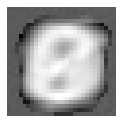

In [ ]:

counter = 1
plt.figure(figsize=(2,2))
plt.axis('off')
k = 0
for item in model.parameters():
  if k <= 6:
    k += 1
    continue
  print(item.shape)
  img_weights = torch.reshape(item, (28, 28))
  plt.axis('off')
  plt.imshow(img_weights.detach().numpy(),cmap="gray")

  break

In [ ]:
torch.save(model.state_dict(), "Mnist_with_dropout.pt")